In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import joblib

import CustFun as cf

In [2]:
sns.set_theme( font='Arial Unicode Ms',font_scale=0.8,rc={'figure.figsize':(10,6)})

In [3]:
warnings.filterwarnings('ignore', category=FutureWarning)

In [4]:
df = pd.read_csv('./dataset/dataset_month.csv',index_col=0)
print(len(df))

# df.set_index('date', inplace=True)

2052


In [5]:
df_for_train = df.copy()

In [6]:
df_for_train = cf.get_three_label(df_for_train,0.05)
# df_for_train = cf.get_binary_label(df_for_train,0.05)

In [7]:
print('scale:',cf.compute_lable_count(df_for_train.loc[df_for_train['label']!=-1]['label'],False,False))

scale: [1008, 48, 995]


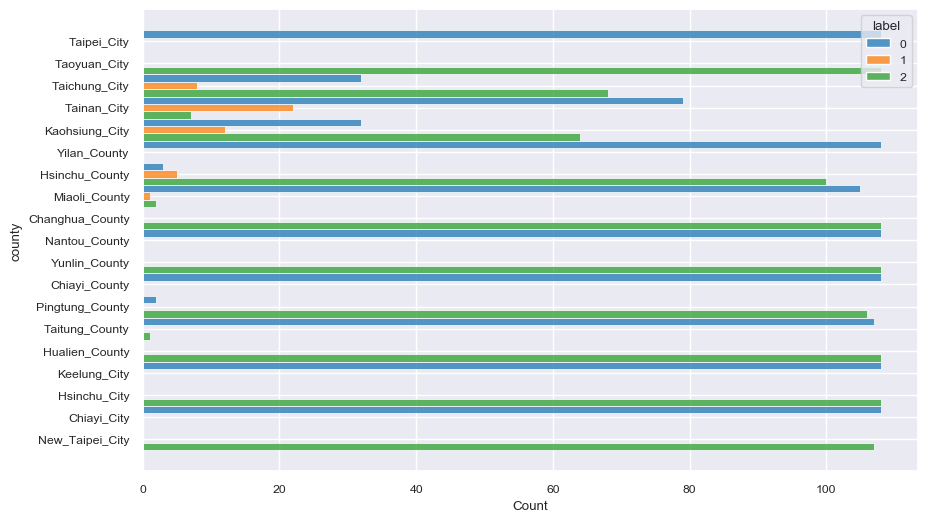

In [8]:
g = sns.histplot(data=df_for_train.loc[df_for_train['label']!=-1],y='county',hue='label', multiple="dodge",palette='tab10',bins=100)
plt.show()

In [9]:
# minmax_scaler = joblib.load("./model/minmax_scaler.kpl")

X_train,y_train,X_val,y_val,X_test,y_test,minmax_scaler,dic_feature_cols = cf.create_training_data(df_for_train,12,
                                                                                                   is_binary=False,
                                                                                                   encoder_path ='./model/encoder.pkl',
                                                                                                   decoder_path ='./model/decoder.pkl',
                                                                                                   train_size=0.6,val_size=0.2)

joblib.dump(minmax_scaler, "./model/minmax_scaler.kpl")

Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



['./model/minmax_scaler.kpl']

In [10]:
print('train',X_train[0].shape,X_train[1].shape,y_train.shape,cf.compute_lable_count(y_train,False,True),'\n',
      ' val',X_val[0].shape,X_val[1].shape,y_val.shape,cf.compute_lable_count(y_val,False,True),'\n',
      'test',X_test[0].shape,X_test[1].shape,y_test.shape,cf.compute_lable_count(y_test,False,True))

train (1083, 19) (1083, 12, 31) (1083, 3) [519, 20, 544] 
  val (361, 19) (361, 12, 31) (361, 3) [183, 17, 161] 
 test (361, 19) (361, 12, 31) (361, 3) [188, 7, 166]


In [11]:
import os
import tensorflow as tf

tf.config.experimental.list_physical_devices('GPU') 
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

In [12]:
class_weight = {0:1.08,1:53.15,2:0.99}

In [13]:
study = cf.TuningUsageOptunaOB(X_train,y_train,X_val,y_val,100,15,
                               continue_train=True,
                               is_binary=False,
                               class_weight=class_weight,
                               study_path='./model/optuna_tuning_three.kpl')

  0%|          | 0/15 [00:00<?, ?it/s]

[0]Values:[1.2037403583526611, 0.04709141328930855, 0.32061028480529785, 0.002770083025097847, 0.125],Params:{'unseq_Dense1': 11, 'seq_LSTM': 14, 'seq_Dropout': 0.30203056767253217, 'merge_Dense1': 3, 'lr': 0.00012091412621809907, 'batch_size': 288}
[1]Values:[0.43073904514312744, 0.8947368264198303, 0.9839242696762085, 0.8504155278205872, 0.977707028388977],Params:{'unseq_Dense1': 10, 'seq_LSTM': 29, 'seq_Dropout': 0.45796289874028034, 'merge_Dense1': 10, 'lr': 0.00035292993349178396, 'batch_size': 192}
save: ./model/optuna_tuning_three.kpl


{'unseq_Dense1': 10, 'seq_LSTM': 29, 'seq_Dropout': 0.45796289874028034, 'merge_Dense1': 10, 'lr': 0.00035292993349178396, 'batch_size': 192}
 train loss:   0.5530 train accuracy:  0.8301
 train recall: 0.7618 train precision: 0.8603
 train auc:    0.9345 train f1_score:  0.8080

 val loss:   0.5000 val accuracy:  0.8643
 val recall: 0.8116 val precision: 0.9421
 val auc:    0.9694 val f1_score:  0.8720

 test loss:   0.4871 test accuracy:  0.8670
 test recall: 0.8006 test precision: 0.9698
 test auc:    0.9702 test f1_score:  0.8771



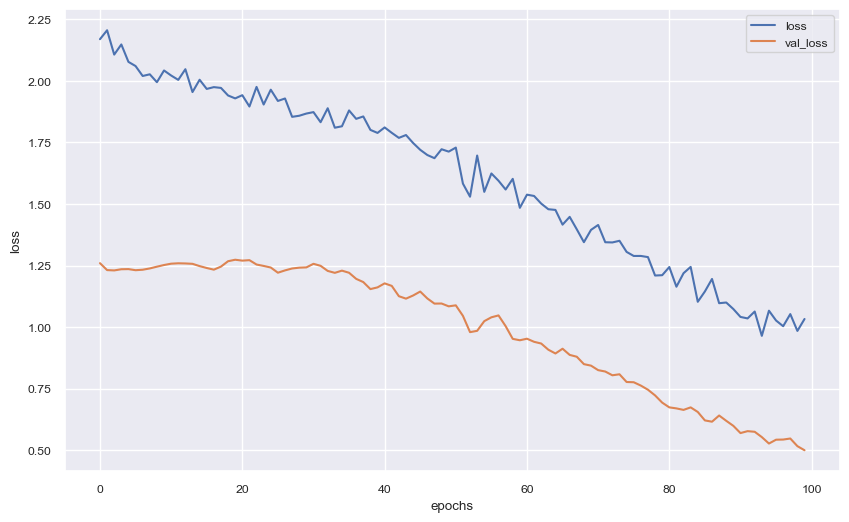

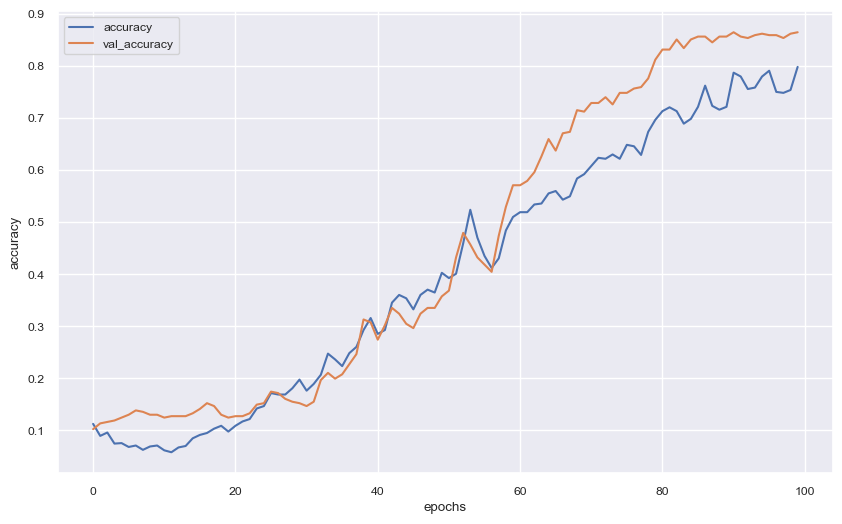

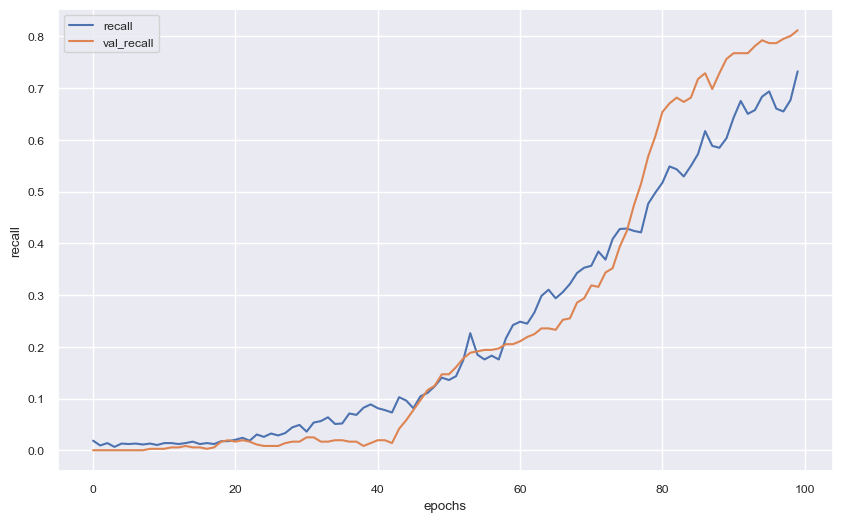

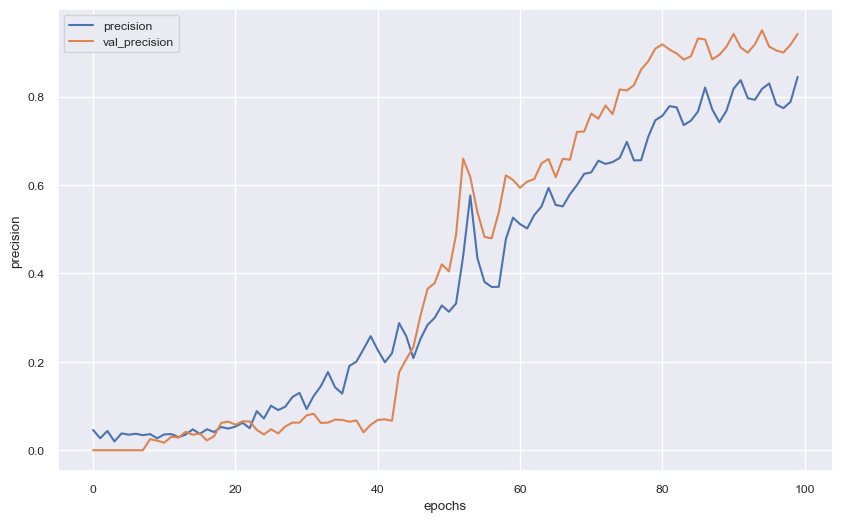

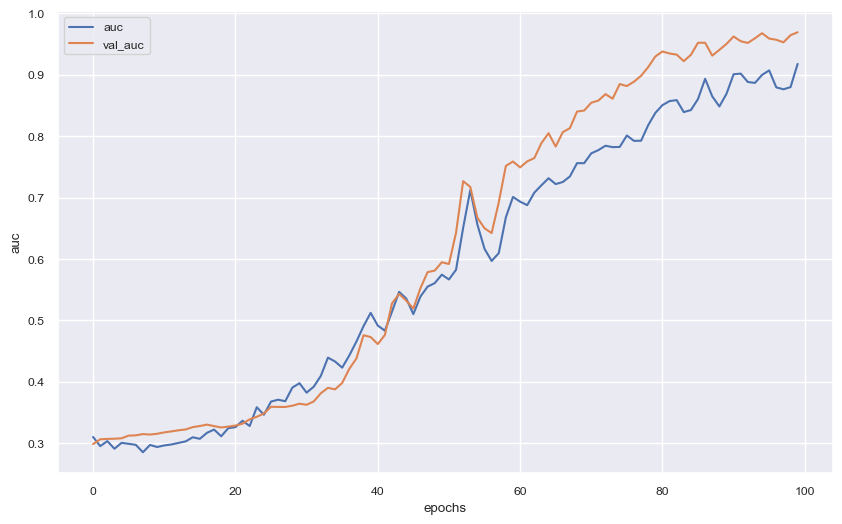

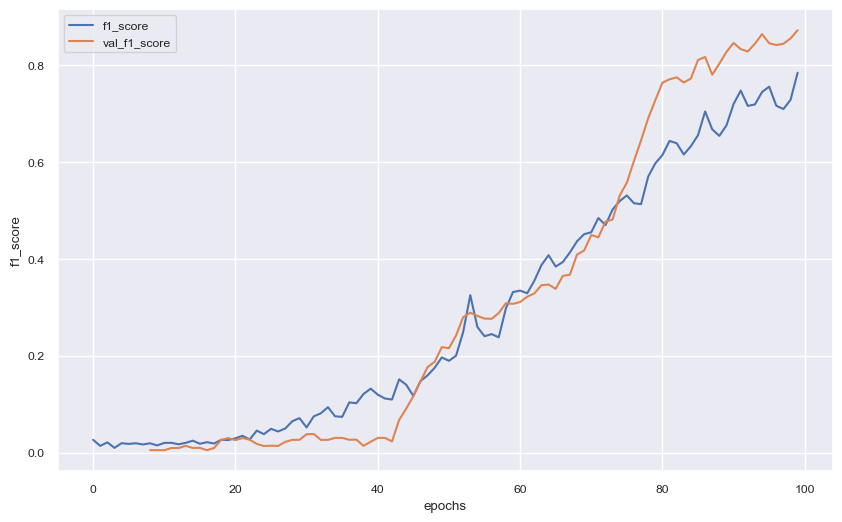

['./model/traffic_model.kpl']

In [14]:
dic_best_params = study.best_trials[-1].params
print(dic_best_params)

# dic_best_params = {'LSTM': 20, 'Dropout': 0.469, 'Dense1': 10, 'lr': 0.001, 'batch_size': 176}

model = cf.train_model(X_train,y_train,X_val,y_val,X_test,y_test,dic_best_params,is_binary=False,class_weight=class_weight,show_result=True,show_history_plot=True)
joblib.dump(model, "./model/traffic_model.kpl")